###**Weights and Biases Tutorial: An Optimized CIFAR CV PyTorch Example**

>Revised Tuesday, December 20, 2022 @author: JD Davis

This example is dervived from a tutorial on computer vision and object recognition available on the Pytorch website here: [Building an Image Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In the Weights and Biases tutorial here we demonstrated the following:

- How to train a convolutional neural network classifier
- Use optimized hyperparameters from W&B Sweep

Now we'll use our optimized parameters to run the original code and look for improvements in accuracy.

Let's get started!

####**Changing three hyper-parameters**

Below we change the learning rate, epochs and batch size according to the optimized training loss in our former hyper-parameter sweep.  The rest of the code remains the same as the tutorial.

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms

# original

#lr = 0.001
#batch_size = 4
#epochs = 2

# optimized

lr = 0.000749
epochs = 10
batch_size = 4

Again, we set up the image transformations, normalize images, create the data loaders and track the classes.

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's take a look at the ground-truth images and labels.


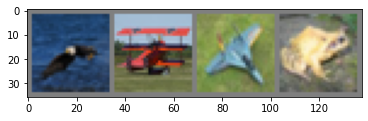

bird  plane plane frog 


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Our convolutional neural network has not changed.

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

Now we begin training using our new hyper-parameters!  Let's see how the model does overall and for each category.

In [20]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.220
[1,  4000] loss: 1.933
[1,  6000] loss: 1.735
[1,  8000] loss: 1.626
[1, 10000] loss: 1.552
[1, 12000] loss: 1.488
[2,  2000] loss: 1.423
[2,  4000] loss: 1.406
[2,  6000] loss: 1.362
[2,  8000] loss: 1.352
[2, 10000] loss: 1.302
[2, 12000] loss: 1.284
[3,  2000] loss: 1.224
[3,  4000] loss: 1.226
[3,  6000] loss: 1.219
[3,  8000] loss: 1.217
[3, 10000] loss: 1.177
[3, 12000] loss: 1.188
[4,  2000] loss: 1.112
[4,  4000] loss: 1.116
[4,  6000] loss: 1.108
[4,  8000] loss: 1.113
[4, 10000] loss: 1.107
[4, 12000] loss: 1.110
[5,  2000] loss: 1.015
[5,  4000] loss: 1.042
[5,  6000] loss: 1.037
[5,  8000] loss: 1.034
[5, 10000] loss: 1.051
[5, 12000] loss: 1.045
[6,  2000] loss: 0.944
[6,  4000] loss: 0.974
[6,  6000] loss: 0.994
[6,  8000] loss: 1.000
[6, 10000] loss: 0.979
[6, 12000] loss: 0.973
[7,  2000] loss: 0.880
[7,  4000] loss: 0.937
[7,  6000] loss: 0.924
[7,  8000] loss: 0.932
[7, 10000] loss: 0.944
[7, 12000] loss: 0.934
[8,  2000] loss: 0.838
[8,  4000] 

In [21]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

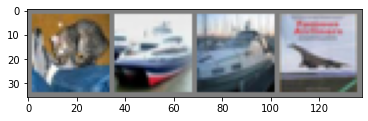

GroundTruth:  cat   ship  ship  plane


In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [23]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  plane


In [26]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [27]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.4 %
Accuracy for class: car   is 76.3 %
Accuracy for class: bird  is 37.2 %
Accuracy for class: cat   is 53.0 %
Accuracy for class: deer  is 54.1 %
Accuracy for class: dog   is 55.5 %
Accuracy for class: frog  is 67.9 %
Accuracy for class: horse is 69.4 %
Accuracy for class: ship  is 81.6 %
Accuracy for class: truck is 70.1 %


The overall accuracy of our optimized run produces accuracy of 63%.  The original tutorial produces accuracy of 56%.


The original results from Pytorch's Tutorial are shown below.  All accuracies improved with the optimized parameters apart from 'ship' and 'horse' class.


| Class       | Accuracy Original (%) | Accuracy Optimized (%) |
|    :----:   |    :----:             |     :----:             |
| overall acc | 56                    | 63                     |
| plane       | 60.7                  | 65.7                   |
| car         | 73.8                  | 77.2                   |
| bird        | 43.8                  | 45.5                   |
| cat         | 39.9                  | 40.1                   |
| deer        | 26.1                  | 63.6                   |
| dog         | 41.7                  | 64.5                   |
| frog        | 65.1                  | 71.2                   |
| horse       | 67.9                  | 61.1                   |
| ship        | 81.8                  | 74.0                   |
| truck       | 63.0                  | 72.3                   |


There are a number of other variables we could optimize in our hyper-parameter sweeps including momentum, criterion and ooptimizers.

###**References**

1. [PyTorch Tutorial on Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
2. [Weights & Biases Documentation](https://docs.wandb.ai/)